In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import difflib

In [2]:
# # Load the dataset (replace 'songs.csv' with your actual file)
file_path = Path('Resources/spotify_dataset.csv')
songs_df = pd.read_csv(file_path)
songs_df.shape

(41099, 20)

In [3]:
# Remove duplicate songs
songs_df = songs_df.drop_duplicates(subset=['track', 'artist'], keep='first')

print(f"DataFrame after removing duplicates: {songs_df.shape}")

DataFrame after removing duplicates: (39996, 20)


In [4]:
songs_df['decade'] = songs_df['decade'].replace({
    '60s': 1960.0,
    '70s': 1970.0,
    '80s': 1980.0,
    '90s': 1990.0,
    '00s': 2000.0, 
    '10s': 2010.0
}).astype(float)

/var/folders/zb/zlwnk3g95gq8bzw6chr9cs_m0000gn/T/ipykernel_93669/2433580227.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  songs_df['decade'] = songs_df['decade'].replace({


In [5]:
# Select relevant features for the model

features = [
# 'track',
#  'artist',
#  'uri',
 'danceability',
 'energy',
#  'key',
#  'loudness',
#  'mode',
#  'speechiness',
 'acousticness',
 'instrumentalness',
#  'liveness',
 'valence',
#  'tempo',
#  'duration_ms',
#  'time_signature',
#  'chorus_hit',
#  'sections',
 'popularity',
#  'decade'
 ]
X = songs_df[features]



In [6]:
print(X.dtypes)

danceability        float64
energy              float64
acousticness        float64
instrumentalness    float64
valence             float64
popularity            int64
dtype: object


In [7]:
# Scale the features

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
X.head(6)

,danceability,energy,acousticness,instrumentalness,valence,popularity
0,0.417,0.620,0.490,0.000000,0.845,1
1,0.498,0.505,0.018,0.107000,0.797,0
2,0.657,0.649,0.846,0.000004,0.908,0
3,0.590,0.545,0.706,0.024600,0.967,0
4,0.515,0.765,0.857,0.000872,0.906,0
5,0.697,0.673,0.714,0.919000,0.778,0


In [9]:
print(X_scaled[4])

[-0.14107835  0.73619092  1.45343439 -0.50490411  1.35902854 -1.00637093]


In [10]:
# Train a k-Nearest Neighbors model
model = NearestNeighbors(n_neighbors=15, algorithm='ball_tree')
model.fit(X_scaled)

NearestNeighbors(algorithm='ball_tree', n_neighbors=15)

In [11]:
def recommend_songs(song_title, artist_name, num_recommendations=5):

    # Normalize user input to lowercase and strip extra spaces
    song_title = song_title.strip().lower()
    artist_name = artist_name.strip().lower()

    # Normalize dataset columns for comparison
    songs_df['track_lower'] = songs_df['track'].str.strip().str.lower()
    songs_df['artist_lower'] = songs_df['artist'].str.strip().str.lower()

    # Filter the dataset for the input song and artist with case-insensitive partial matching
    song_row = songs_df[
        (songs_df['track_lower'].str.contains(song_title)) & 
        (songs_df['artist_lower'].str.contains(artist_name))
    ]
    
    if song_row.empty:
        print(f"Error: Song '{song_title}' by '{artist_name}' not found in the dataset.")
        return

    # Get the index and features of the input song
    song_index = song_row.index[0]
    song_features = X_scaled[song_index].reshape(1, -1)

    # Find nearest neighbors
    distances, indices = model.kneighbors(song_features)
    
    # Map indices back to the original DataFrame
    original_indices = songs_df.index
    recommendations = []
    for i in indices.flatten():
        original_index = original_indices[i]  # Map to original index
        if (songs_df.loc[original_index, 'track_lower'] != song_row.iloc[0]['track_lower'] and 
            songs_df.loc[original_index, 'artist_lower'] != song_row.iloc[0]['artist_lower']):
            recommendations.append((songs_df.loc[original_index, 'track'], songs_df.loc[original_index, 'artist']))
        if len(recommendations) >= num_recommendations:
            break

    # Print recommendations with the correct original case for song and artist names
    original_song = song_row.iloc[0]['track']
    original_artist = song_row.iloc[0]['artist']
    
    print(f"Recommendations for '{original_song}' by {original_artist}:")
    for track, artist in recommendations:
        print(f"- {track} by {artist}")

# Example usage
recommend_songs("california dreamin", "the mamas & the papas", 7)

Recommendations for 'California Dreamin'' by The Mamas & The Papas:
- Ooo La La La by Teena Marie
- Best Friend by 50 Cent & Olivia
- Big Log by Robert Plant
- Ready Or Not Here I Come (Can't Hide From Love) by The Delfonics
- Hey! Baby by Bruce Channel
- Killer Queen by Queen
- Where Evil Grows by The Poppy Family


In [12]:
from time import time

algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
for algo in algorithms:
    start_time = time()
    model = NearestNeighbors(n_neighbors=15, algorithm=algo)
    model.fit(X_scaled)
    print(f"Algorithm: {algo}, Time Taken: {time() - start_time:.4f} seconds")

Algorithm: auto, Time Taken: 0.0176 seconds
Algorithm: ball_tree, Time Taken: 0.0120 seconds
Algorithm: kd_tree, Time Taken: 0.0096 seconds
Algorithm: brute, Time Taken: 0.0005 seconds


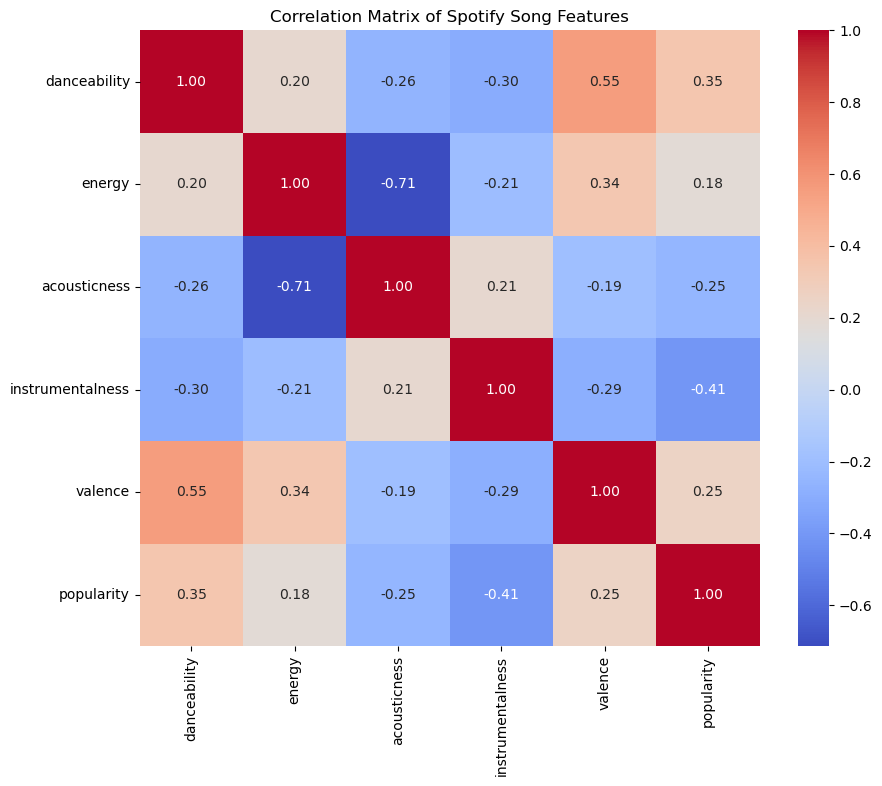

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for the original features (before scaling)
correlation_matrix = X.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Spotify Song Features")
plt.show()